<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab/v0.8.0/03_vqe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up CUDA-Q Environment**

In [1]:
#The following commands are used to set up the environment in Colab
%pip install cuda-quantum==0.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.8/148.8 MB 5.9 MB/s eta 0:00:00


# Cost Minimization

Below, we start with a basic example of a hybrid variational algorithm that involves flipping the Bloch vector of a qubit from the $|{0}\rangle$ state to the $|{1}\rangle$ state. First, we import the relevant packages and set our backend to simulate our workflow on NVIDIA GPUs.

In [2]:
import cudaq
from typing import List

cudaq.set_target("nvidia")

In [3]:
# Initialize a kernel/ ansatz and variational parameters.
@cudaq.kernel
def kernel(angles: List[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(angles[0], qubit)
    ry(angles[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = cudaq.spin.z(0)

# Initial gate parameters which intialize the qubit in the zero state
initial_parameters = [0, 0]

print(cudaq.draw(kernel, initial_parameters))

     ╭───────╮╭───────╮
q0 : ┤ rx(0) ├┤ ry(0) ├
     ╰───────╯╰───────╯



We build our cost function such that its minimal value corresponds to the qubit being in the $|{1}\rangle$ state. The `observe` call below allows us to simulate our state vector $|{\psi}\rangle$ and calculate

$$ \langle \psi | Z | \psi \rangle. $$

In [4]:
cost_values = []


def cost(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(kernel, hamiltonian,
                                      parameters).expectation()
    cost_values.append(expectation_value)
    return expectation_value

In [5]:
# We see that the initial value of our cost function is one, demonstrating that our qubit is in the zero state
initial_cost_value = cost(initial_parameters)
print(initial_cost_value)

1.0


Below we use our built-in optimization suite to minimize the cost function. We will be using the gradient-free COBYLA alogrithm.

In [6]:
# Define a CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_parameters

result = optimizer.optimize(dimensions=2, function=cost)

Text(0, 0.5, 'Cost Value')

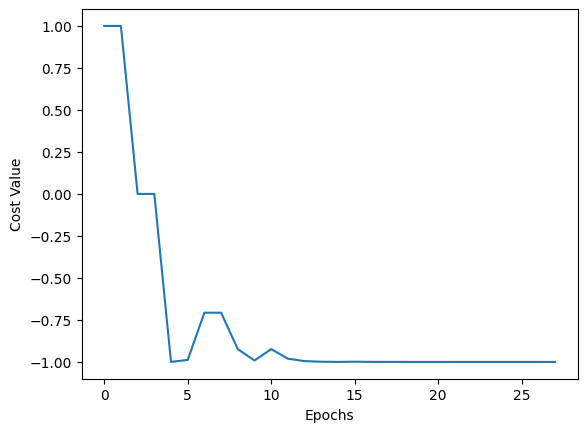

In [7]:
# Plotting how the value of the cost function decreases during the minimization procedure.
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")

We see that the final value of our cost function,

$$ \langle \psi | Z | \psi \rangle = -1, $$

demonstrating that the qubit is in the $|{1}\rangle$ state.

# Variational Quantum Eigensolver

A common application of the Variational Quantum Eigensolver (VQE) algorithm is to compute the ground state energy of a molecular system. The code below demonstrates how to perform classical preprocessing for a $H_2$ molecule (i.e. obtain the integrals from a Hartree-Fock computation to build the molecular Hamiltonian), prepare the initial Hartree-Fock state on the quantum register, add the parameterized UCCSD ansatz to the kernel, and select the COBYLA optimizer.  We are then ready to call `cudaq:vqe` to estimate the minimum energy of the system.

In [8]:
!pip install openfermionpyscf==0.5

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.8 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=3d24cacc122d1124af68118c56f214b391608e059678cf6d2a9f80ba1f136a3a
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [9]:
import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# Single precision
cudaq.set_target("nvidia")
# Double precision
#cudaq.set_target("nvidia-fp64")

The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance.

The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration.

Let us first begin by defining the molecule and other metadata about the problem.


In [10]:
# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

We now generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from the template provided by CUDA-Q.  

In [11]:
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

### Using CUDA-Q Optimizers

We use the builtin optimizers within CUDA-Q for the minimization procedure.

In [12]:
optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(energy)

-1.1371740035195181


### Integration with Third-Party Optimizers

We can also integrate popular libraries like scipy with CUDA-Q.

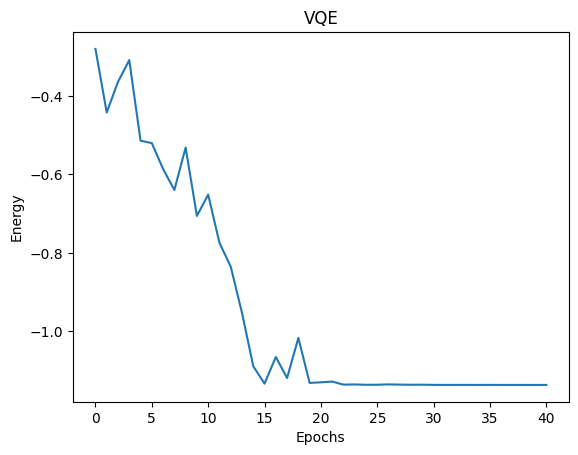

In [13]:
# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

# Quantum Approximate Optimization Algorithm

Here we build up a kernel for QAOA with `p` layers, with each layer containing the alternating set of unitaries corresponding to the problem and the mixer Hamiltonians. The algorithm leverages the VQE algorithm to compute the Max-Cut of a 3-regular (each node connects with 3 edges) graph generated below.

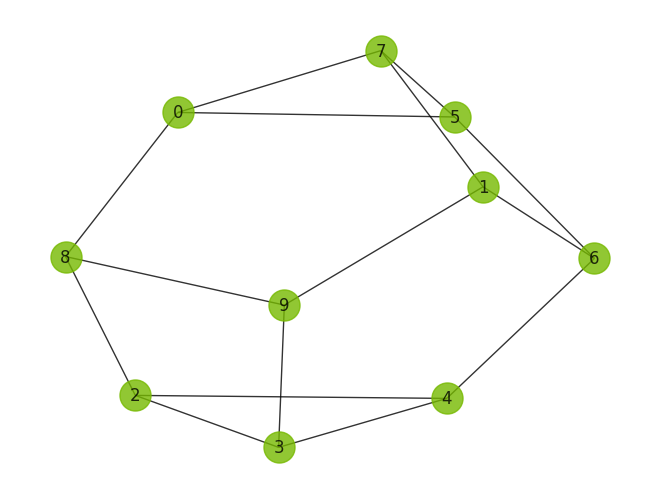

In [14]:
import networkx as nx
import random

num_nodes = 10

random.seed(13)
edges = nx.random_regular_graph(3, num_nodes).edges()
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, node_color='#76B900')

In [15]:
import cudaq
from cudaq import spin

from typing import List

import numpy as np



# The problem Hamiltonian
hamiltonian = 0    # Initialize the hamiltonian object
for (i, j) in edges:
    hamiltonian += 0.5 * spin.z(i) * spin.z(j)

pairs = [int(node) for edge in edges for node in edge]


# Problem parameters.
qubit_count = num_nodes
layer_count: int = 2
parameter_count: int = 2 * layer_count


@cudaq.kernel
def kernel_qaoa(qubit_count: int, pairs: List[int], layer_count: int, thetas: List[float]):
    """QAOA ansatz for Max-Cut"""
    qvector = cudaq.qvector(qubit_count)

    # Create superposition
    h(qvector)

    # Loop over the layers
    for layer in range(layer_count):
        # Loop over the qubits
        # Problem unitary
        for i in range(int(len(pairs)/2)):
            q1, q2 = pairs[2*i], pairs[2*i+1]
            x.ctrl(qvector[q1], qvector[q2])
            rz(2.0 * thetas[layer], qvector[q2])
            x.ctrl(qvector[q1], qvector[q2])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])


# Specify the optimizer and its initial parameters. Make it repeatable.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.COBYLA()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)
print(cudaq.draw(kernel_qaoa, qubit_count, pairs, layer_count, optimizer.initial_parameters))

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064]
     ╭───╮                                                                   »
q0 : ┤ h ├──●──────────────────●────●──────────────────●────●────────────────»
     ├───┤  │                  │    │                  │    │                »
q1 : ┤ h ├──┼──────────────────┼────┼──────────────────┼────┼────────────────»
     ├───┤  │                  │    │                  │    │                »
q2 : ┤ h ├──┼──────────────────┼────┼──────────────────┼────┼────────────────»
     ├───┤  │                  │    │                  │    │                »
q3 : ┤ h ├──┼──────────────────┼────┼──────────────────┼────┼────────────────»
     ├───┤  │                  │    │                  │    │                »
q4 : ┤ h ├──┼──────────────────┼────┼──────────────────┼────┼────────────────»
     ├───┤  │                  │  ╭─┴─╮╭────────────╮╭─┴─╮  │                »
q5 : ┤ h ├──┼────────────

In [16]:
import time


# Define the simulation target:
cudaq.set_target("nvidia")  # "nvidia" for GPU, "qpp-cpu" for CPU


# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, pairs, layer_count,
                         parameters).expectation()


# Optimize!
t0 = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)
print("Execution time =", round(time.time()-t0, 3), "(s)")

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
counts = cudaq.sample(kernel_qaoa, qubit_count, pairs, layer_count, optimal_parameters, shots_count=2**18)
print(counts)

max = 0
for bitstring in counts:
    if counts[bitstring] > max:
        max = counts[bitstring]
        bitstring_max = bitstring
print("The optimal bitstring with max. number of shots =", bitstring_max)

Execution time = 0.518 (s)
Optimal value =  -3.2731325600235515
Optimal parameters =  [-0.34244254629196363, -0.8398784859960708, 0.23450065185067387, 0.25946099212603224]
{ 0001111111:233 0111011111:14 1011011111:6 0001011111:669 1010011111:2 0010011111:600 1100011111:2 0100011111:2 1101101111:10 0001101111:521 0110101111:18 1010101111:13 1100101111:18 0100101111:41 1000101111:650 0111001111:18 1011001111:87 1001001111:266 0001001111:1252 1110001111:33 0110001111:8 0100001111:37 1000001111:8 0111110111:1 1011110111:2 0101110111:13 1001110111:22 0001110111:695 1110110111:4 1010110111:1 0100110111:373 1000110111:70 1111010111:3 1011010111:2 1001010111:1 0010010111:75 1000010111:2 0001100111:24 1110100111:38 0110100111:38 1001000111:25 0001000111:22 1011000111:13 0110000111:2 1111111011:2 0111111011:17 0011111011:22 1110111011:12 0010111011:63 0100111011:20 0111011011:25 1011011011:44 0101011011:12 1001011011:82 0001011011:431 0110011011:64 1000011011:7 1111101011:12 0011101011:5 0101101